In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import os
from torchvision.io import read_image
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch import nn



# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
class DataLoader():
    def __init__(self, img_dir, img_dir2, transform = None, target_transform=None):
        self.img_dir = img_dir
        self.img_dir2 = img_dir2
    def __len__(self):
        return len(self.img_dir)

    def __getitem__(self, idx):
        fileNames = os.listdir(self.img_dir)
        label = fileNames[idx].rsplit("t-mask-", 1 )[1]
        img_path = os.path.join(self.img_dir, fileNames[idx])
        img_path2 = os.path.join(self.img_dir2, label)
        image = read_image(img_path)
        image2 = read_image(img_path2)
        return image, image2

In [3]:
dataset = DataLoader("../Data/with_mask", "../Data/without_mask")

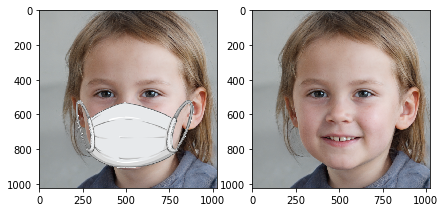

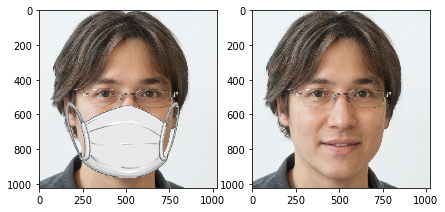

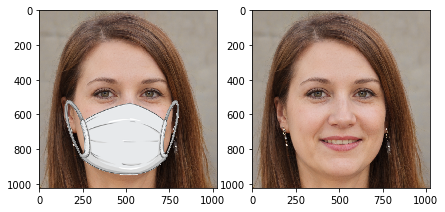

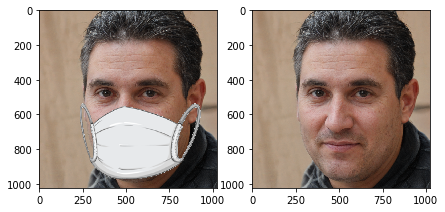

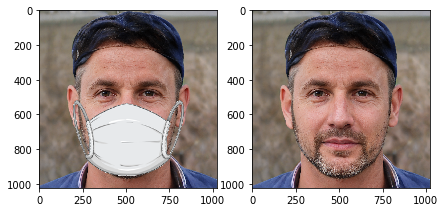

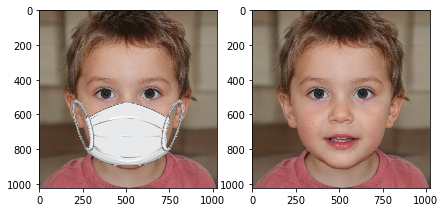

In [4]:
batch_size = 6
trainloader = torch.utils.data.DataLoader(dataset, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=0)
# get some images
dataiter = iter(trainloader)

images, images2 = dataiter.next()
for image, image2 in zip(images,images2): # Run through all samples in a batch
    plt.figure(figsize = (7,7))
    plt.subplot(1,2,1)
    plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
    plt.subplot(1,2,2)
    plt.imshow(np.transpose(image2.numpy(), (1, 2, 0)))

Størrelsen på vores billeder

In [5]:
image.size()

torch.Size([3, 1024, 1024])

Vi bliver nok nødt til at resize vores billeder - de er for store => vi får for mange parametere vores model skal træne.

In [6]:
p = transforms.Compose([transforms.Scale((75,75))])

In [7]:
image_resize = p(image)

In [8]:
image_resize.size()

torch.Size([3, 75, 75])

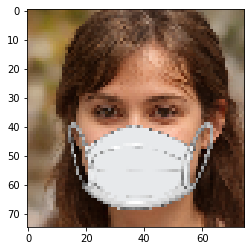

In [9]:
plt.imshow(np.transpose(image_resize.numpy(), (1, 2, 0)))

In [10]:
image_resize.view(-1).size()

torch.Size([16875])

Netværk - taget med inspiration fra VAE_exercise.ipynb.

In [11]:
bottleneck_size = 25


class VAE(nn.Module):
    def __init__(self):
        
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(16875, 50)
        self.fc21 = nn.Linear(50, bottleneck_size)
        self.fc22 = nn.Linear(50, bottleneck_size)
        self.fc3 = nn.Linear(bottleneck_size, 50)
        self.fc4 = nn.Linear(50, 16875)

    def encode(self, x):
        x  = x.view(-1)
        h1 = F.relu(self.fc1(x))
        mu = self.fc21(h1)
        log_sigma = self.fc22(h1)
        return mu, log_sigma

    def reparameterize(self, mu, log_sigma):
        std = torch.exp(0.5*log_sigma)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return self.fc4(h3)

    def forward(self, x):
        mu, log_sigma = self.encode(x)
        z = self.reparameterize(mu, log_sigma)
        return self.decode(z), mu, log_sigma


Initialisere klasse og optimizer

In [12]:
vae = VAE()
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

In [41]:
type(image)

torch.Tensor

In [45]:
p=transforms.Compose([transforms.Scale((75,75))])

mean = 0
std = 1

transform = transforms.Compose(
    [transforms.Normalize((mean, mean, mean), (std, std, std)),
    transforms.Scale((75,75))])

In [44]:
img = transform(image.float())
img = p(img)
img

tensor([[[127.6733, 123.3401, 119.3667,  ..., 130.3667, 123.6999, 122.7800],
         [128.0200, 125.0396, 124.0273,  ..., 127.9727, 124.9804, 128.6329],
         [131.6333, 130.6533, 129.3667,  ..., 129.4644, 125.0200, 125.0000],
         ...,
         [197.7531, 200.3794, 199.3667,  ...,  54.4011,  60.8946,  70.6877],
         [198.3267, 202.0196, 199.0000,  ...,  59.2866,  63.9395,  57.6603],
         [200.4734, 199.0065, 191.7333,  ...,  60.8735,  66.3602,  69.8733]],

        [[ 89.6733,  88.9800,  90.0000,  ..., 116.0000, 109.3332, 105.1067],
         [ 94.0000,  92.0200,  94.2813,  ..., 113.9927, 110.0000, 111.6599],
         [ 97.8802,  96.6333,  99.2322,  ..., 114.3667, 111.9927, 108.0000],
         ...,
         [176.1198, 177.3667, 177.3667,  ...,  29.5355,  31.5552,  40.7277],
         [176.3267, 180.0196, 177.0000,  ...,  32.6333,  34.9199,  27.6468],
         [176.3467, 178.0000, 173.7931,  ...,  31.1001,  35.3401,  36.5466]],

        [[ 45.0000,  46.0000,  45.0000,  ...

Data

In [13]:
batch_size = 256
mean = 0.5
std = 0.5

p=transforms.Compose([transforms.Scale((75,75))])



trainloader = torch.utils.data.DataLoader(dataset, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=0)
# get some images
dataiter = iter(trainloader)



In [14]:
def loss_function(recon_x, x, mu, z_log_sigma):
    loss = nn.MSELoss()
    print(recon_x.size())
    print(x.size())
    BCE = loss(recon_x, x)
    print(f"BCE: {BCE}")
    KLD = 0.5* torch.sum( z_log_sigma.exp() + mu.pow(2) - z_log_sigma   - 1)
    KLD *= 5
    
    return BCE + KLD

def draw(model):
    img = model(X_test)[0].detach().numpy()
    img = img.reshape((-1, 100, 100)).transpose((1, 0, 2)).reshape(-1, 10*28)
    #img = img * 0.3081 + 0.1307

    axs[1].imshow(img, cmap='gray')
    fig.canvas.draw()


def train(epoch):
    vae.train()
    train_loss = 0
    
    dataiter = iter(trainloader)
    images, images2 = dataiter.next()
    for image, image2 in zip(images,images2): # Run through all samples in a batch
        img_mask = transform(image)
        img_no_mask = transform(image2)
        
        #img_mask = p(img_mask).float()
        #img_no_mask = p(img_no_mask).float()
        
        img_no_mask = img_no_mask.view(-1)
        
        optimizer.zero_grad()
        
        recon_batch, mu, log_sigma = vae(img_mask)
        print(recon_batch)
        #if batch_idx % 100 == 0:
        #    draw(vae)
        
        
        loss = loss_function(recon_batch, img_no_mask, mu, log_sigma)
        
        loss.backward()
        
        train_loss += loss.item()
        optimizer.step()
    print(f"{epoch}: {train_loss / batch_size*16875}")

In [15]:
for epoch in range(1, 20):
    train(epoch)

TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

In [143]:
dataiter = iter(trainloader)

images, images2 = dataiter.next()

for image, image2 in zip(images,images2): # Run through all samples in a batch
    img_mask = p(image).float()
    img_no_mask = p(image2).float()
     

In [66]:
dataiter = iter(trainloader)
images, images2 = dataiter.next()
for image, image2 in zip(images,images2): # Run through all samples in a batch
    img_mask = p(image).float()
    img_no_mask = p(image2).float()
             
    recon_batch, mu, log_sigma = vae(img_mask)
     

In [69]:
out = recon_batch.view(3,75,75).deta

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


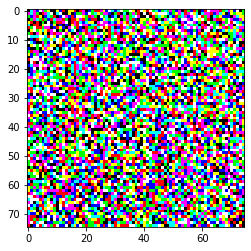

In [71]:
plt.imshow(np.transpose(out.detach().numpy(), (1, 2, 0)))